In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
from scipy import interpolate as interp
import scipy.ndimage
import matplotlib.pylab as pl
import time
import cv2 as cv
import ot
import math

# Define Sliced Wass & Sliced Wass Grad

In [3]:
def SWgrad(u,v,nbProj):#Pour deux images de même taille
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    random_state = np.random.RandomState(None)
    Teta = random_state.normal(0., 1., [nbProj, d])
    np.linalg.norm(Teta)
    norm = np.linalg.norm(Teta, ord=2, axis=1, keepdims=True)
    Teta = Teta / norm
    Res = np.zeros((N,M,d))
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        Iu_sorted = np.argsort(uteta)
        Iv_sorted = np.argsort(vteta)
        sigma = np.zeros(N*M)
        sigma[Iu_sorted] = Iv_sorted
        for j in range(N*M):
                Res[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = Res[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] + np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] - v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)], Teta[i])*Teta[i]
        
        
    Res = Res*2/nbProj
    
    return Res
                
    
def SW(u,v,nbProj):#Pour deux images de même taille 
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    random_state = np.random.RandomState(None)
    Teta = random_state.normal(0., 1., [nbProj, d])
    np.linalg.norm(Teta)
    norm = np.linalg.norm(Teta, ord=2, axis=1, keepdims=True)
    Teta = Teta / norm
    SW = 0
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        u_sorted = np.sort(uteta)
        v_sorted = np.sort(vteta)
        SW = SW + np.sum((u_sorted - v_sorted)**2)
    SW = SW/nbProj
    
    return SW

# Descente de Gradient sur l'image X (haute res spatiale et spectrale)

On va résoudre le problème suivant :

$\underset{X}{\inf} 
 SW_2^2(L_H , XR) + SW_2^2(L_M , LX) + \mu||X - \overline{X}	||^2$


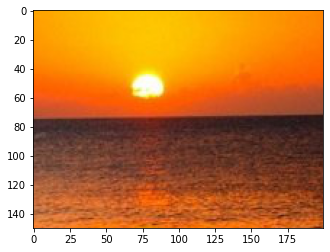

In [4]:
I1 = plt.imread('../data/coucher.jpg')
Xtrue = I1[100:250, 450:650, :]/255
plt.imshow(Xtrue)

In [5]:
def spectrale_degradation(img, b_low, b_high, adjoint):
    if(adjoint == 0):
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_low))
        for i in range(b_low):
            for j in range(d):
                out[:,:,i] = out[:,:,i] + img[:,:,j]
            
            out[:,:,i] = out[:,:,i]/d
        return out
    else :
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_high))
        for i in range(b_high):
            out[:,:,i] = 1/3*img[:,:,0]
        return out  

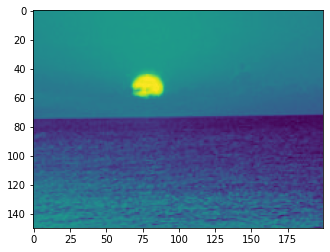

In [6]:
L_M = spectrale_degradation(Xtrue, 1, 3, 0)
plt.imshow(L_M)

In [7]:
def spatial_degradation(img,K,adjoint):
    sx , sy, d = img.shape[0], img.shape[1], img.shape[2]
    GaussBlur = cv.getGaussianKernel(5,5)
    GaussBlur_adj = GaussBlur.transpose()
        
    if adjoint==0: #Blur de l'image + sous-echantillonnage 
        imgBlurred = cv.filter2D(img, -1, GaussBlur)#Blur de l'image
        #Sous-echantillonnage
        Sx = math.floor(sx/K)
        Sy = math.floor(sy/K)
        out = np.zeros([Sx,Sy,d])
        for x in range(Sx):
            for y in range(Sy):
                tmp=0
                for k in range(K):
                    for l in range(K):
                        tmp += imgBlurred[K*x+k,K*y+l, :]
                out[x,y,:]=tmp
                
    else: #sur-echantillonnage + Adjoint Blur (convolution avec transposee du Kernel de Blur)
        Sx = sx*K
        Sy = sy*K
        out = np.zeros([Sx,Sy,d])
        for x in range(sx):
            for y in range(sy):
                for k in range(K):
                    for l in range(K):
                        out[K*x+k,K*y+l]= img[x,y]
        out = cv.filter2D(out, -1, GaussBlur_adj)#Adjoint du Blur
    
    return out/(K*K)

In [8]:
L_H = spatial_degradation(Xtrue, 2, 0)

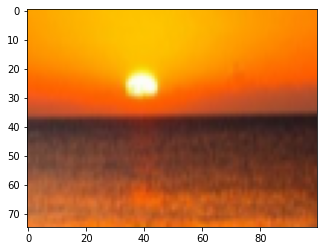

In [9]:
plt.imshow(L_H)

In [10]:
def reech_interp(img, K_ech):
    imgRec = np.zeros((K_ech*img.shape[0], K_ech*img.shape[1], img.shape[2]))
    for i in range(img.shape[2]):
        imgRec[:,:,i] = scipy.ndimage.zoom(img[:,:,i], K_ech, order=3)
    return imgRec

In [69]:
def Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj):
    SW1 = SW(spatial_degradation(X, K_ech, 0), L_H, nbProj)
    SW2 = SW(spectrale_degradation(X, b_low, b_high, 0), L_M, nbProj)
    L2 = mu*np.linalg.norm(X-reech_interp(L_H, K_ech))**2
    
    return Lbd_SW1*SW1 + Lbd_SW2*SW2 + L2

In [106]:
def grad_Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj):
    g1 = spatial_degradation(SWgrad(spatial_degradation(X, K_ech, 0), L_H, nbProj), K_ech, 1)
    g2 = spectrale_degradation(SWgrad(spectrale_degradation(X, b_low, b_high, 0), L_M, nbProj), b_low, b_high, 1)
    g3 = 2*(X-reech_interp(L_H, K_ech))
    return Lbd_SW1*g1 + Lbd_SW2*g2 + mu*g3

In [13]:
def pasArmijo(out, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, sigma, teta):
    i = 0
    pasMax = 1.0
    pas = pasMax
    fct = Fonctionnelle(out, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
    g = np.linalg.norm(grad)
    while(fct-Fonctionnelle(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj) < sigma*pas*g**2):
        pas = pasMax * teta**i
        #pas = pas/2
        i += 1
        if(pas <= 0.000001):
            return 0
    
    return pas

def pasWolf(out, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, sigma, teta):
    i = 0
    pasMax = 1.0
    pas = pasMax
    fct = Fonctionnelle(out, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
    g = np.linalg.norm(grad)
    while(fct-Fonctionnelle(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj) < sigma*pas*g**2) and (g*np.linalg.norm(grad_Fonctionnelle(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)) < sigma*pas*g**2):
        pas = pasMax * teta**i
        #pas = pas/2
        i += 1
        if(pas <= 0.000001):
            return 0
    
    return pas

In [14]:
def RechercheLineaire(out, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, sigma, teta):
    i = 0
    alpha_l = 0
    alpha_r = 10000
    pas = 1.0
    fct = Fonctionnelle(out, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
    g = np.linalg.norm(grad)
    while(fct-Fonctionnelle(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj) < sigma*pas*g**2) or (g*np.linalg.norm(grad_Fonctionnelle(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)) < sigma*pas*g**2):
        if(fct-Fonctionnelle(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj) < sigma*pas*g**2):#Pas trop long
            alpha_r = pas
            pas = (alpha_l+alpha_r)/2
        else:
            if(g*np.linalg.norm(grad_Fonctionnelle(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)) < sigma*pas*g**2):
                alpha_l = pas
                pas = (alpha_l+alpha_r)/2
        i = i+1
        if(pas <= 0.000001):
            return 0
    return pas
                

In [15]:
def gradientDescente_pasConstant(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, pas):
    X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    Fct = [Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)]#fonctionnelle a minimiser

    nu = 10**-4
    
    grad = grad_Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
    X = X - pas*grad
    Fct.append(Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj))
    
    i = 1
    while(np.abs(Fct[i]-Fct[i-1])**2/np.abs(Fct[i-1])**2 > nu and i <10000):
        grad = grad_Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
        X = X - pas*grad
        Fct.append(Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj))
        #if(i%10 == 0):
        print( 'iter = ', i , "fonction = ", Fct[i])

        i = i+1
    
    return X, Fct


def gradientDescente_pasRL(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj):
    X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    
    Fct = [Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)]#fonctionnelle a minimiser
    
    sigma = 10**-3
    teta = 0.2
    #teta = 0.05
    nu = 10**-4
    
    grad = grad_Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
    pas = RechercheLineaire(X, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, sigma, teta)
    X = X - pas*grad
    Fct.append(Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj))
    
    i = 1
    while( np.abs(Fct[i]-Fct[i-1])**2/np.abs(Fct[i-1])**2 > nu and i <10000):
        grad = grad_Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj)
        pas = RechercheLineaire(X, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, sigma, teta)
        X = X - pas*grad
        Fct.append(Fonctionnelle(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj))
        
        #if(i%10 == 0):
        print( 'iter = ', i , 'pas = ', pas, "fonction = ", Fct[i])

        i = i+1
    
    return X, Fct

In [46]:
X, Fct = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 5, 1, 1, 3, 0.2)

iter =  1 fonction =  1005.7160306832913
iter =  2 fonction =  223.6748103614279
iter =  3 fonction =  65.06666988740277
iter =  4 fonction =  17.730467061160255
iter =  5 fonction =  10.935075755548311
iter =  6 fonction =  5.812965461644692
iter =  7 fonction =  3.696318219713895
iter =  8 fonction =  2.3977952161258798
iter =  9 fonction =  1.9185394789483918
iter =  10 fonction =  1.6762819922891938
iter =  11 fonction =  1.4991966643820722
iter =  12 fonction =  1.4659362928873787
iter =  13 fonction =  1.407479432359366
iter =  14 fonction =  1.4255817788680674
iter =  15 fonction =  1.3235765809205593
iter =  16 fonction =  1.432924205974662
iter =  17 fonction =  1.4146914998075562
iter =  18 fonction =  1.316945990862032


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


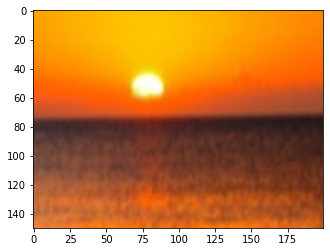

In [49]:
plt.imshow(X)

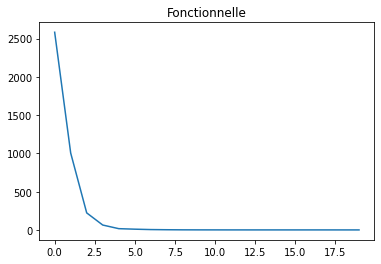

In [50]:
plt.plot(Fct)
plt.title("Fonctionnelle")
plt.show()

In [22]:
X, Fct = gradientDescente_pasRL(L_H, L_M, 2, 1, 3, 1, 100, 1, 5)

iter =  1 pas =  0.5 fonction =  5202.698662381811
iter =  2 pas =  0.5 fonction =  921.6026109095445
iter =  3 pas =  0.5 fonction =  224.9432688216387
iter =  4 pas =  0.5 fonction =  66.29694004135543
iter =  5 pas =  1.0 fonction =  57.81093457045265
iter =  6 pas =  0.5 fonction =  57.126007363093755
iter =  7 pas =  1.0 fonction =  55.23322360962818
iter =  8 pas =  0.5 fonction =  53.492899433463315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


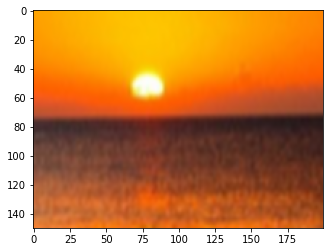

In [23]:
plt.imshow(X)

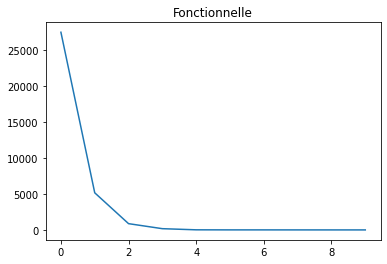

In [24]:
plt.plot(Fct)
plt.title("Fonctionnelle")
plt.show()

# Définition des différentes métriques d'erreur

In [16]:
import skimage
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [17]:
def PSNR(reference, reconstruct):
    mse = np.mean((reference - reconstruct) ** 2)
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [18]:
def aSAM(reference, reconstruct):
    N = reference.shape[0]
    M = reference.shape[1]
    asam = 0
    for j in range(N*M):
        ps = np.dot(reference[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], reconstruct[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)].transpose())
        norm = np.linalg.norm(reference[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)])*np.linalg.norm(reconstruct[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)])
        asam = asam + np.arccos(ps/norm)
    asam = asam/(N*M)
    return asam

In [19]:
def acSSIM(reference, reconstruct):
    l = reference.shape[2]
    acssim = 0
    for i in range(l):
        acssim = acssim + skimage.metrics.structural_similarity(reference[:,:,i], reconstruct[:,:,i])
    acssim = 1 - acssim/l
    return acssim    

# Tests pour plusieurs valeurs de mu

iter =  1 pas =  0.0078125 fonction =  8185.989441767386
iter =  2 pas =  0.0078125 fonction =  4459.745735869689
iter =  3 pas =  0.0078125 fonction =  2457.7934641325146
iter =  4 pas =  0.0078125 fonction =  1375.8316448694127
iter =  5 pas =  0.0078125 fonction =  768.5470224974747
iter =  6 pas =  0.0078125 fonction =  433.82836785876015
iter =  7 pas =  0.0078125 fonction =  243.7223830039868
iter =  8 pas =  0.0078125 fonction =  138.41427051834137
iter =  9 pas =  0.0078125 fonction =  78.12828142867536
iter =  10 pas =  0.0078125 fonction =  44.51614103920624
iter =  11 pas =  0.0078125 fonction =  25.594453659803087
iter =  12 pas =  0.0078125 fonction =  14.749133249935074
iter =  13 pas =  0.0078125 fonction =  8.895717337217192
iter =  14 pas =  0.0078125 fonction =  5.305984623595357
iter =  15 pas =  0.0078125 fonction =  3.658700973163133
iter =  16 pas =  0.0078125 fonction =  2.383114443901266
iter =  17 pas =  0.0078125 fonction =  2.067685435503588
iter =  18 pas = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 100
Fonctionnelle pour mu = 100


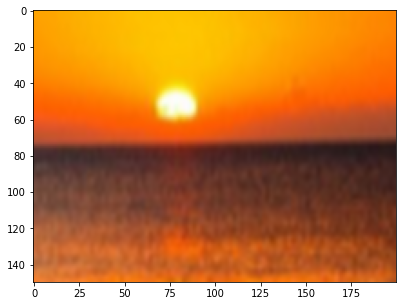

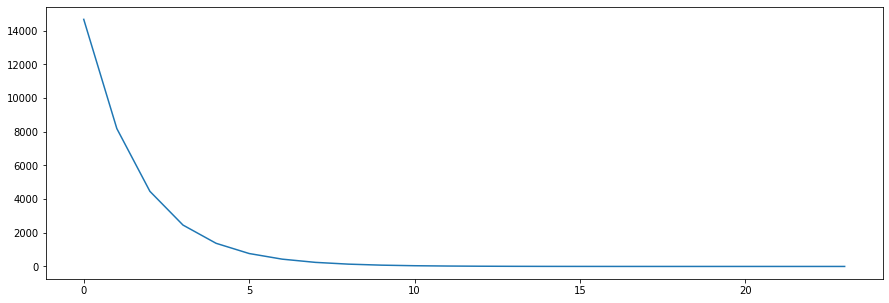

iter =  1 pas =  0.015625 fonction =  4420.148700984515
iter =  2 pas =  0.015625 fonction =  2307.7756197662025
iter =  3 pas =  0.015625 fonction =  1255.0468443613518
iter =  4 pas =  0.015625 fonction =  700.3383104307436
iter =  5 pas =  0.015625 fonction =  387.69139988904567
iter =  6 pas =  0.015625 fonction =  220.51398124845502
iter =  7 pas =  0.015625 fonction =  123.66874977515982
iter =  8 pas =  0.015625 fonction =  70.84859918751793
iter =  9 pas =  0.015625 fonction =  40.23396809887563
iter =  10 pas =  0.015625 fonction =  23.196410367423393
iter =  11 pas =  0.015625 fonction =  13.598877430892017
iter =  12 pas =  0.015625 fonction =  7.990988107673746
iter =  13 pas =  0.015625 fonction =  5.163607017293671
iter =  14 pas =  0.015625 fonction =  3.186457781678224
iter =  15 pas =  0.015625 fonction =  2.541040905844492
iter =  16 pas =  0.015625 fonction =  1.8287505072100083
iter =  17 pas =  0.015625 fonction =  1.7869610265600875
iter =  18 pas =  0.0078125 fon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 50
Fonctionnelle pour mu = 50


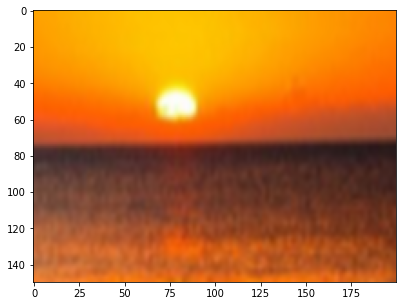

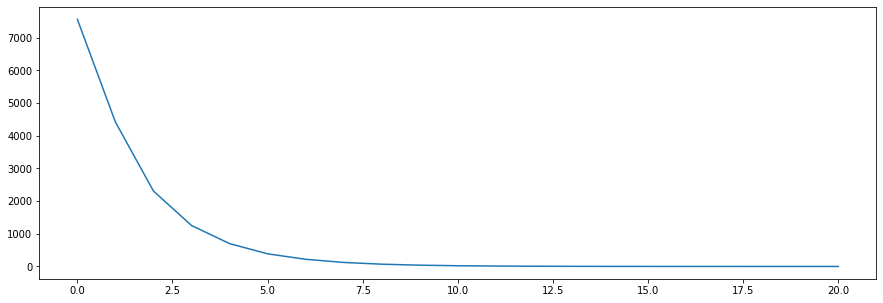

iter =  1 pas =  0.0625 fonction =  449.5595767214361
iter =  2 pas =  0.0625 fonction =  99.51169376075289
iter =  3 pas =  0.0625 fonction =  24.675264597290187
iter =  4 pas =  0.0625 fonction =  7.287095523337035
iter =  5 pas =  0.0625 fonction =  2.8414833056306827
iter =  6 pas =  0.03125 fonction =  1.5287113385758935
iter =  7 pas =  0.03125 fonction =  1.4489273774731526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 10
Fonctionnelle pour mu = 10


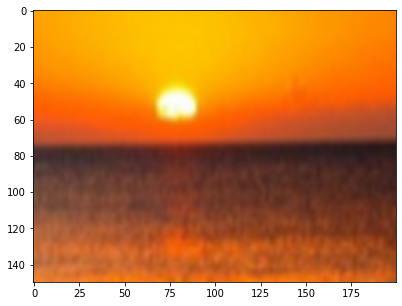

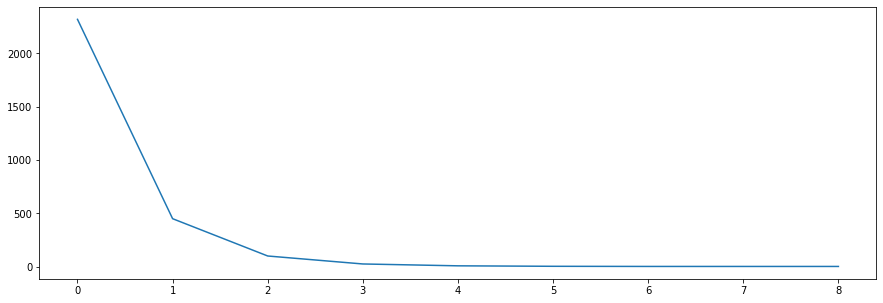

iter =  1 pas =  0.125 fonction =  296.4292201561901
iter =  2 pas =  0.125 fonction =  62.0963985761403
iter =  3 pas =  0.125 fonction =  15.72794564815537
iter =  4 pas =  0.125 fonction =  5.379113570071189
iter =  5 pas =  0.125 fonction =  2.3970094609841
iter =  6 pas =  0.0625 fonction =  1.3970078185115673


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 5
Fonctionnelle pour mu = 5


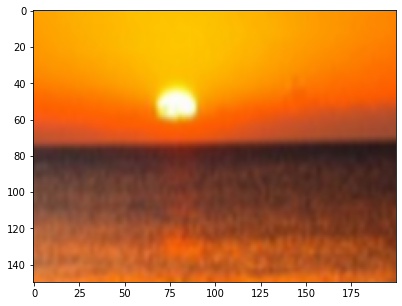

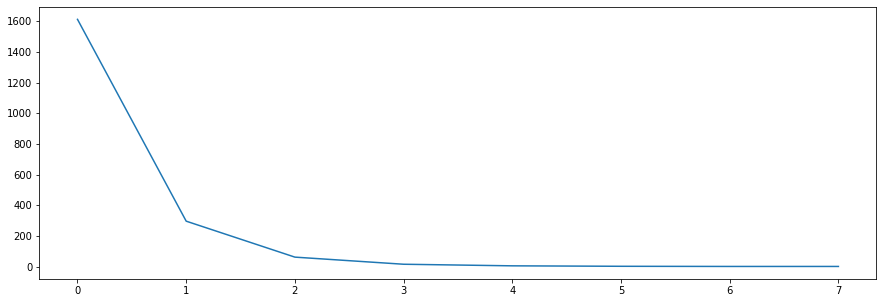

iter =  1 pas =  0.5 fonction =  63.44297729619193
iter =  2 pas =  0.5 fonction =  14.42528459176258
iter =  3 pas =  0.5 fonction =  4.532552437816926
iter =  4 pas =  0.5 fonction =  1.6589901559133884
iter =  5 pas =  0.5 fonction =  1.1376249035051704
iter =  6 pas =  0.5 fonction =  1.0094785839283955
iter =  7 pas =  0.125 fonction =  0.982081057073537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 1
Fonctionnelle pour mu = 1


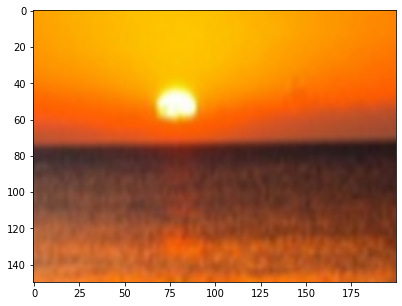

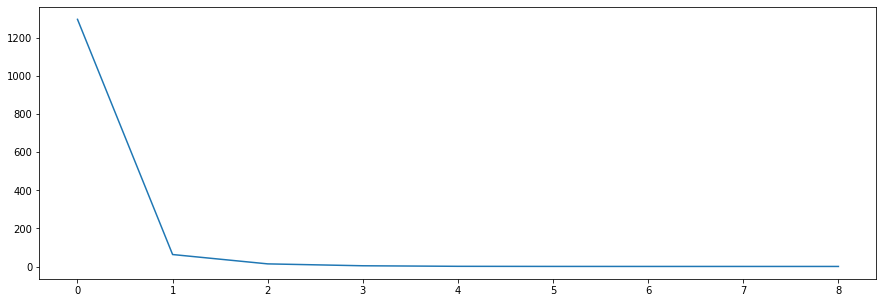

iter =  1 pas =  1.0 fonction =  169.38873594729498
iter =  2 pas =  1.0 fonction =  97.15666036469742
iter =  3 pas =  1.0 fonction =  67.71992508466504
iter =  4 pas =  1.0 fonction =  64.9439654831132
iter =  5 pas =  1.0 fonction =  49.55080184659329
iter =  6 pas =  1.0 fonction =  35.244581947259135
iter =  7 pas =  1.0 fonction =  22.08355173906563
iter =  8 pas =  1.0 fonction =  11.792131068844117
iter =  9 pas =  1.0 fonction =  9.770955271677233
iter =  10 pas =  1.0 fonction =  7.333194847683076
iter =  11 pas =  1.0 fonction =  5.279832112480258
iter =  12 pas =  1.0 fonction =  3.148409726686088
iter =  13 pas =  1.0 fonction =  2.774473940805877
iter =  14 pas =  1.0 fonction =  1.9588147058711436
iter =  15 pas =  1.0 fonction =  1.8312555492415457
iter =  16 pas =  1.0 fonction =  1.2305668791382995
iter =  17 pas =  1.0 fonction =  1.2525177971258619
iter =  18 pas =  1.0 fonction =  1.0447665130444475
iter =  19 pas =  1.0 fonction =  1.0041315272453974
iter =  20 pa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.5
Fonctionnelle pour mu = 0.5


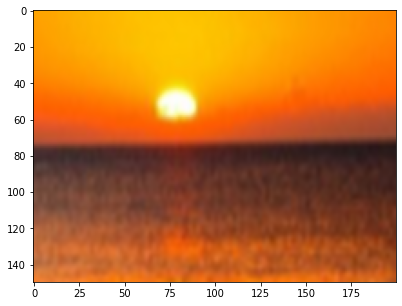

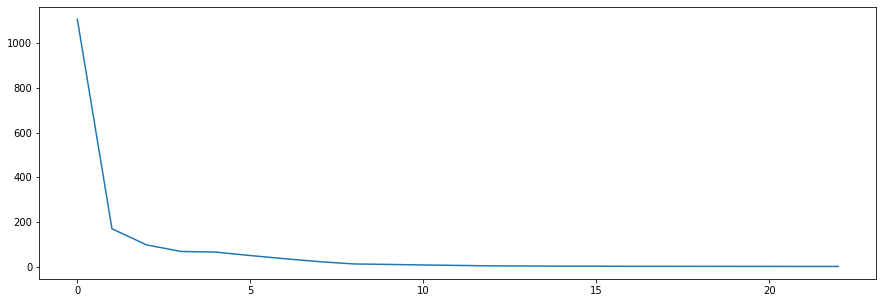

iter =  1 pas =  1.0 fonction =  215.55410627505594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.1
Fonctionnelle pour mu = 0.1


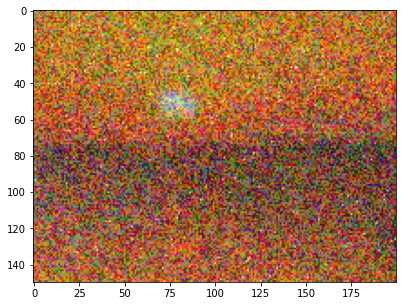

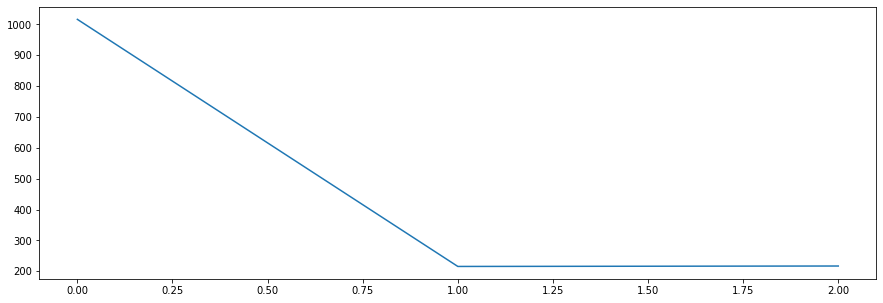

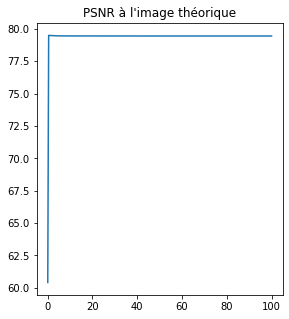

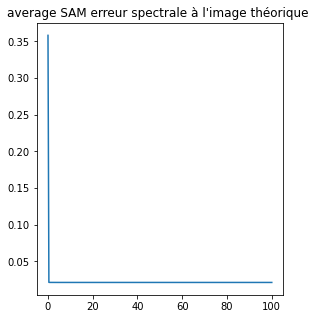

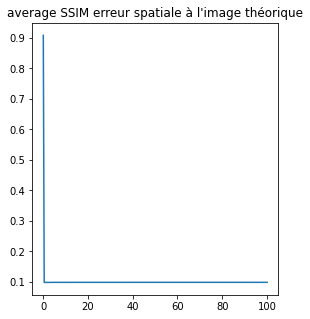

In [25]:
mu = [100, 50, 10, 5, 1, 0.5, 0.1]
errPSNR = []
errASAM = []
errACSSIM = []
for i in range(len(mu)):
    X, Fct = gradientDescente_pasRL(L_H, L_M, 2, 1, 3, 1, 1, mu[i], 5)
    errPSNR.append(PSNR(Xtrue, X))
    errASAM.append(aSAM(Xtrue, X))
    errACSSIM.append(acSSIM(Xtrue, X))
    print('Image reconstruire pour mu = '+str(mu[i])+'')
    plt.figure(figsize=(15,5))
    plt.imshow(X)
    print('Fonctionnelle pour mu = '+str(mu[i])+'')
    plt.figure(figsize=(15,5))
    plt.plot(Fct)
    plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(mu,errPSNR)
plt.title("PSNR à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(mu,errASAM)
plt.title("average SAM erreur spectrale à l'image théorique ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(mu,errACSSIM)
plt.title("average SSIM erreur spatiale à l'image théorique")

plt.show()

iter =  1 fonction =  179.7872275364055
iter =  2 fonction =  33.91712989038699
iter =  3 fonction =  7.536054902443896
iter =  4 fonction =  2.9245008646919715
iter =  5 fonction =  1.6933603116601252
iter =  6 fonction =  1.346883461109416
iter =  7 fonction =  1.3223254665665412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 3
Fonctionnelle pour mu = 3


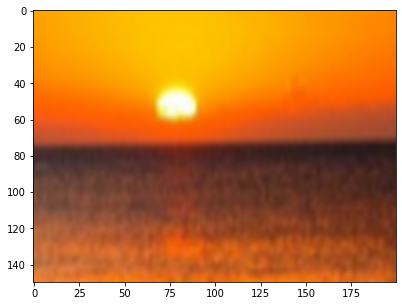

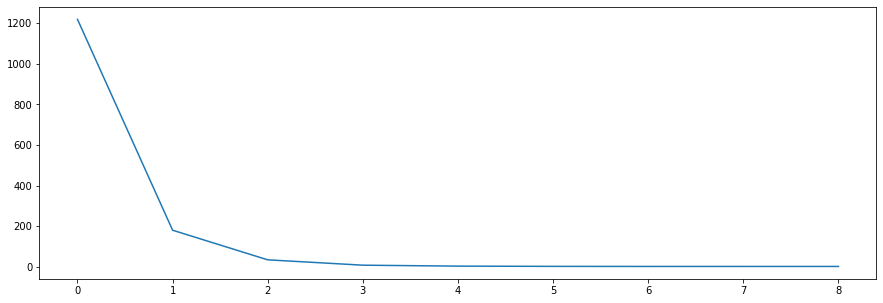

iter =  1 fonction =  94.47349157804956
iter =  2 fonction =  9.822826350298644
iter =  3 fonction =  2.461433111065911
iter =  4 fonction =  1.2990640739540156
iter =  5 fonction =  1.220173030822367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 2
Fonctionnelle pour mu = 2


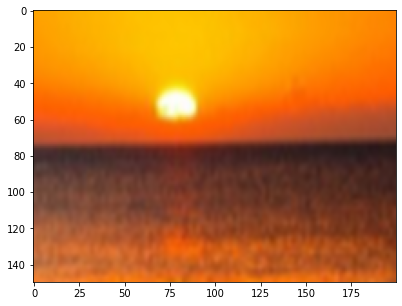

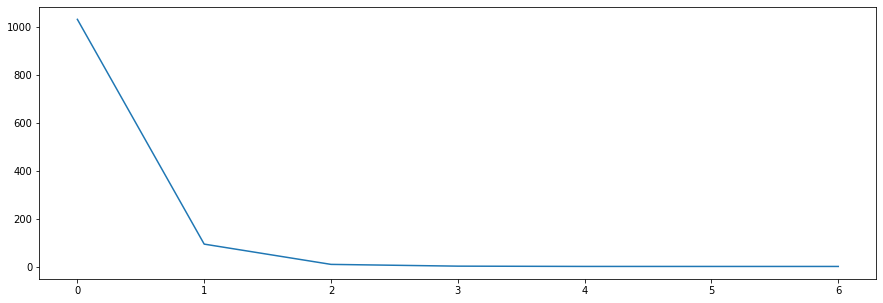

iter =  1 fonction =  403.7525432450569
iter =  2 fonction =  195.40427224601095
iter =  3 fonction =  63.978743037609675
iter =  4 fonction =  30.074517201353398
iter =  5 fonction =  13.553537390910005
iter =  6 fonction =  7.100248143589671
iter =  7 fonction =  4.188638783003615
iter =  8 fonction =  2.6466736332796654
iter =  9 fonction =  1.7745506851762525
iter =  10 fonction =  1.3418313238994282
iter =  11 fonction =  1.146919341471567
iter =  12 fonction =  1.032627235508574
iter =  13 fonction =  1.0054078663474733
iter =  14 fonction =  0.9855478917092855
iter =  15 fonction =  0.9628842855227381
iter =  16 fonction =  0.9890559787191877
iter =  17 fonction =  0.9723081628927014


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 1
Fonctionnelle pour mu = 1


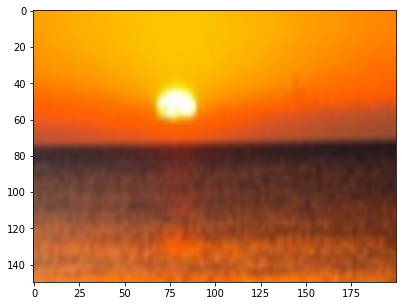

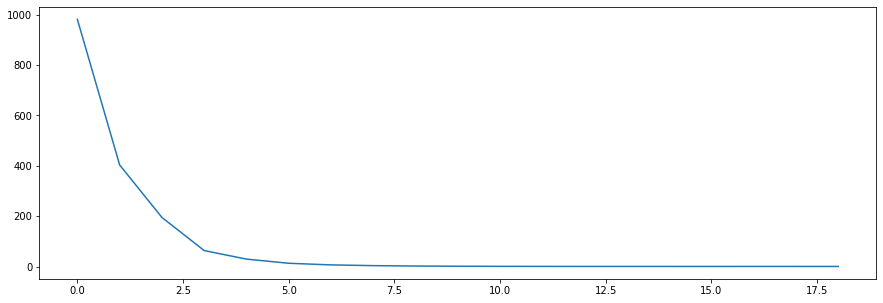

iter =  1 fonction =  424.0915460712482
iter =  2 fonction =  268.71401355831057
iter =  3 fonction =  98.94210886302406
iter =  4 fonction =  38.83942657274403
iter =  5 fonction =  18.580095537630584
iter =  6 fonction =  10.207713305538238
iter =  7 fonction =  6.4368841859713
iter =  8 fonction =  3.702624241060843
iter =  9 fonction =  2.477341477351041
iter =  10 fonction =  1.7153813064886303
iter =  11 fonction =  1.3445379401814976
iter =  12 fonction =  1.1394974223298846
iter =  13 fonction =  1.0278403981745239
iter =  14 fonction =  0.9456053859349327


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.9
Fonctionnelle pour mu = 0.9


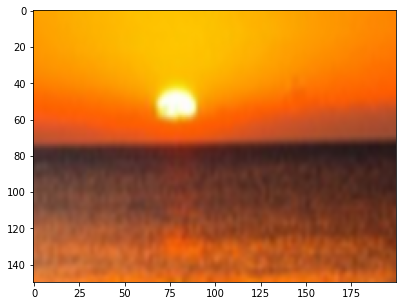

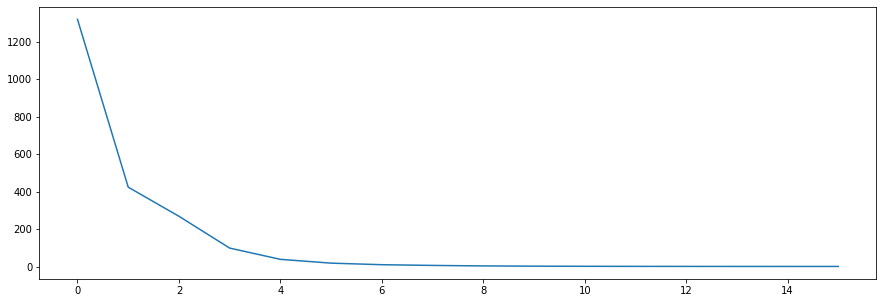

iter =  1 fonction =  478.6244212897093
iter =  2 fonction =  275.54540528804245
iter =  3 fonction =  142.53597022487824
iter =  4 fonction =  60.28736457207441
iter =  5 fonction =  29.038146443659134
iter =  6 fonction =  16.55363656981971
iter =  7 fonction =  9.844750306547416
iter =  8 fonction =  5.706007456253101
iter =  9 fonction =  3.9451706862274785
iter =  10 fonction =  2.6804805228612185
iter =  11 fonction =  1.907164479630529
iter =  12 fonction =  1.448067398907102
iter =  13 fonction =  1.2229331532694476
iter =  14 fonction =  1.0186040276318398
iter =  15 fonction =  0.9865210010786651
iter =  16 fonction =  0.9103997567554188
iter =  17 fonction =  0.8992629018463492
iter =  18 fonction =  0.9110697210005327


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.8
Fonctionnelle pour mu = 0.8


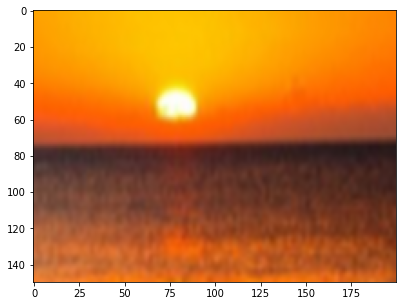

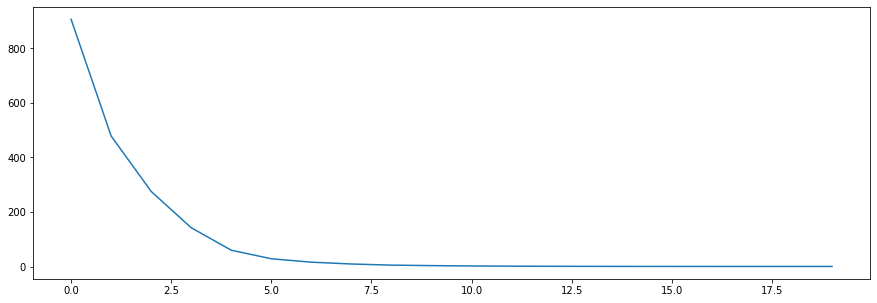

iter =  1 fonction =  733.7402163022106
iter =  2 fonction =  341.00774174414124
iter =  3 fonction =  142.65767734941244
iter =  4 fonction =  86.72509973320473
iter =  5 fonction =  41.5263200639841
iter =  6 fonction =  27.003226825797373
iter =  7 fonction =  16.296902934983287
iter =  8 fonction =  10.406964402111061
iter =  9 fonction =  6.393414350404628
iter =  10 fonction =  3.877557148501032
iter =  11 fonction =  2.706074234690566
iter =  12 fonction =  2.1130182484542686
iter =  13 fonction =  1.6701297489143667
iter =  14 fonction =  1.3865007530226063
iter =  15 fonction =  1.1451007568964529
iter =  16 fonction =  1.0021894884286313
iter =  17 fonction =  0.9477154965831472
iter =  18 fonction =  0.8870125215072755
iter =  19 fonction =  0.8680151050528752
iter =  20 fonction =  0.828320526011921
iter =  21 fonction =  0.8426184172658011
iter =  22 fonction =  0.854628203749066
iter =  23 fonction =  0.8377937558115778


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.7
Fonctionnelle pour mu = 0.7


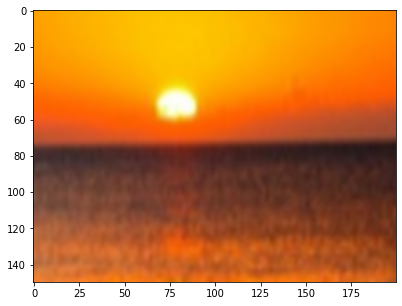

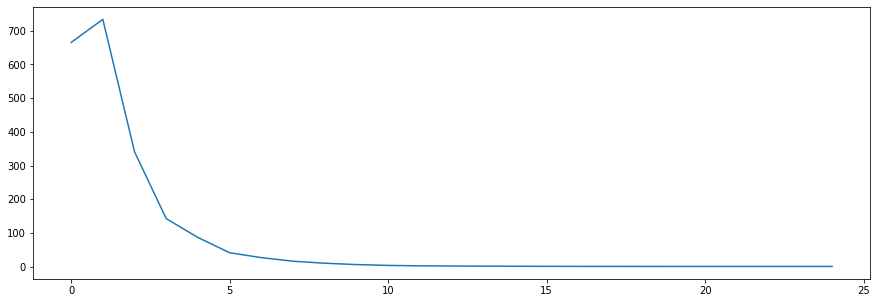

iter =  1 fonction =  685.0433751024925
iter =  2 fonction =  435.34649030551213
iter =  3 fonction =  189.0246772327202
iter =  4 fonction =  115.27822008276792
iter =  5 fonction =  73.38337983853208
iter =  6 fonction =  33.04194993691902
iter =  7 fonction =  18.764880073525916
iter =  8 fonction =  13.77673033600124
iter =  9 fonction =  10.447339047504592
iter =  10 fonction =  5.975394303058485
iter =  11 fonction =  4.616566377632923
iter =  12 fonction =  3.3259668813216328
iter =  13 fonction =  2.41541353743329
iter =  14 fonction =  1.9429398074209376
iter =  15 fonction =  1.6002132314969006
iter =  16 fonction =  1.3427459473904553
iter =  17 fonction =  1.1330053505612152
iter =  18 fonction =  0.987568029640737
iter =  19 fonction =  0.9118795451050626
iter =  20 fonction =  0.8612500304695431
iter =  21 fonction =  0.8093728586980236
iter =  22 fonction =  0.7948102257188892
iter =  23 fonction =  0.8119029806276596
iter =  24 fonction =  0.7830555196962871
iter =  25 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.6
Fonctionnelle pour mu = 0.6


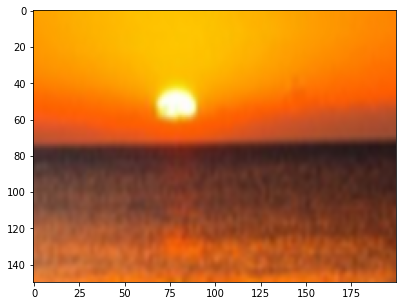

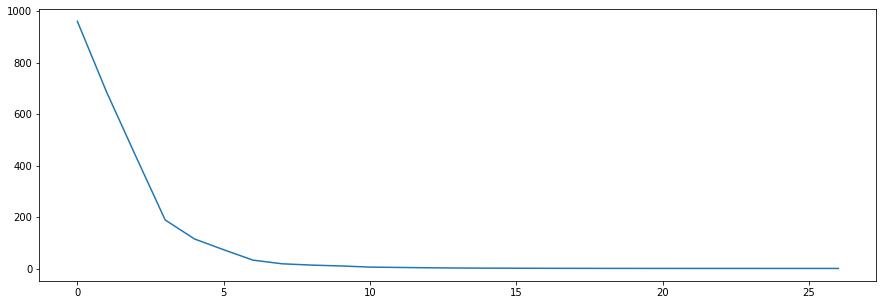

iter =  1 fonction =  706.4466700933987
iter =  2 fonction =  384.56024175454115
iter =  3 fonction =  267.65484491721236
iter =  4 fonction =  203.06546010048842
iter =  5 fonction =  104.77978572621463
iter =  6 fonction =  52.92665127954667
iter =  7 fonction =  43.742894728204924
iter =  8 fonction =  31.996712920227463
iter =  9 fonction =  12.89263412760436
iter =  10 fonction =  11.835042291528541
iter =  11 fonction =  7.399073161257437
iter =  12 fonction =  6.143131206804637
iter =  13 fonction =  5.0904269141422125
iter =  14 fonction =  3.369967649044373
iter =  15 fonction =  2.816611528174656
iter =  16 fonction =  2.126869551086438
iter =  17 fonction =  1.9195386158444119
iter =  18 fonction =  1.4812481165388522
iter =  19 fonction =  1.2080445947270908
iter =  20 fonction =  1.154460406812845
iter =  21 fonction =  0.9895718086286049
iter =  22 fonction =  0.8683772329599188
iter =  23 fonction =  0.8204832315642946
iter =  24 fonction =  0.7840270288469033
iter =  25

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.5
Fonctionnelle pour mu = 0.5


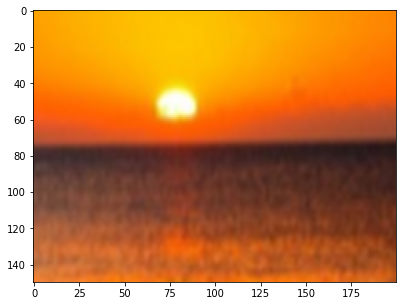

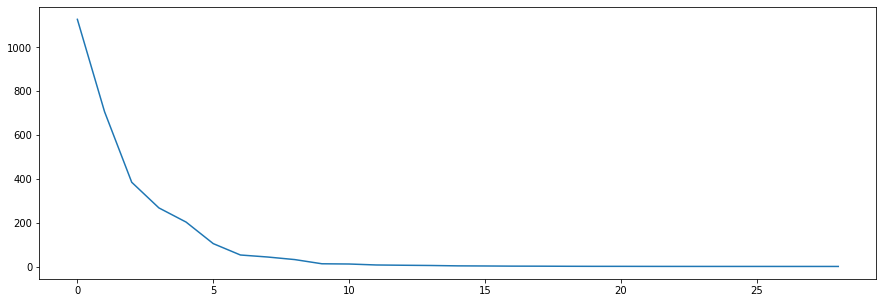

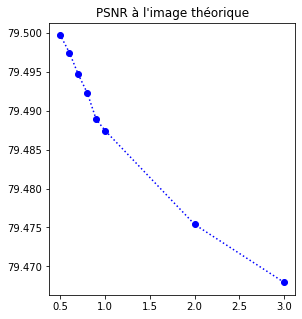

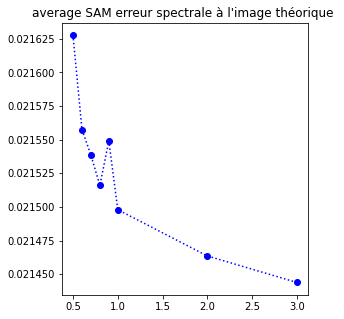

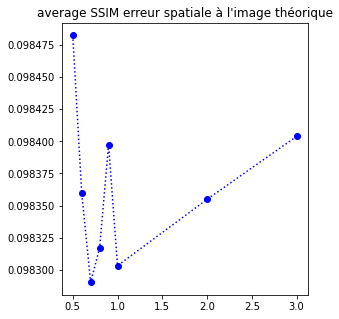

In [65]:
mu = [3, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5]
errPSNR = []
errASAM = []
errACSSIM = []
for i in range(len(mu)):
    X, Fct = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 1, 1, mu[i], 5, 0.2)
    errPSNR.append(PSNR(Xtrue, X))
    errASAM.append(aSAM(Xtrue, X))
    errACSSIM.append(acSSIM(Xtrue, X))
    print('Image reconstruire pour mu = '+str(mu[i])+'')
    plt.figure(figsize=(15,5))
    plt.imshow(X)
    print('Fonctionnelle pour mu = '+str(mu[i])+'')
    plt.figure(figsize=(15,5))
    plt.plot(Fct)
    plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(mu,errPSNR, "b:o")
plt.title("PSNR à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(mu,errASAM, "b:o")
plt.title("average SAM erreur spectrale à l'image théorique ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(mu,errACSSIM, "b:o")
plt.title("average SSIM erreur spatiale à l'image théorique")

plt.show()

In [67]:
X, Fct = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 5, 1, 10, 5, 0.02)

iter =  1 fonction =  2727.8784263528264
iter =  2 fonction =  947.9947329936676
iter =  3 fonction =  479.2411205385605
iter =  4 fonction =  205.5664346928375
iter =  5 fonction =  119.99688798713044
iter =  6 fonction =  65.54754886976555
iter =  7 fonction =  36.13493419120581
iter =  8 fonction =  21.535381613496742
iter =  9 fonction =  12.87074880803365
iter =  10 fonction =  8.35421897951466
iter =  11 fonction =  5.684509291950347
iter =  12 fonction =  4.247370970538952
iter =  13 fonction =  3.6748572034362343
iter =  14 fonction =  3.58084985937332
iter =  15 fonction =  3.438378954366124
iter =  16 fonction =  3.5411809246090824
iter =  17 fonction =  3.4890268769815864
iter =  18 fonction =  3.423343999508033
iter =  19 fonction =  3.4870416480702353
iter =  20 fonction =  3.429588402561083


iter =  1 pas =  0.0078125 fonction =  568221.0165110675
iter =  2 pas =  0.0078125 fonction =  180859.21811428937
iter =  3 pas =  0.0078125 fonction =  57483.7459197886
iter =  4 pas =  0.0078125 fonction =  18287.520236233333
iter =  5 pas =  0.0078125 fonction =  5816.014944888898
iter =  6 pas =  0.0078125 fonction =  1849.5347382591515
iter =  7 pas =  0.0078125 fonction =  588.5021623573699
iter =  8 pas =  0.0078125 fonction =  187.96236762163795
iter =  9 pas =  0.0078125 fonction =  60.442697598664964
iter =  10 pas =  0.0078125 fonction =  19.90508134352953
iter =  11 pas =  0.0078125 fonction =  6.968991550088463
iter =  12 pas =  0.0078125 fonction =  2.869941375011582
iter =  13 pas =  0.0078125 fonction =  1.5825618547312768
iter =  14 pas =  0.0078125 fonction =  1.1769661645721003
iter =  15 pas =  0.0078125 fonction =  1.0405723306464236
iter =  16 pas =  0.001953125 fonction =  1.0045776465993896
iter =  17 pas =  7.62939453125e-06 fonction =  0.9803497052866698
iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 100
Fonctionnelle pour mu = 100


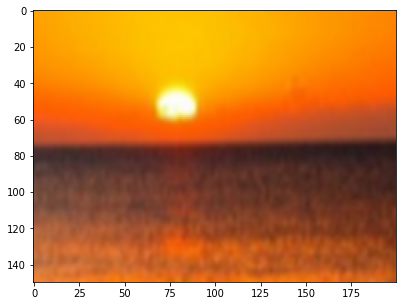

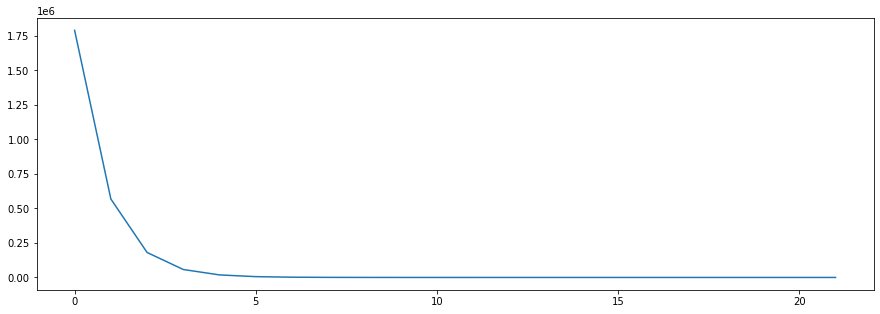

iter =  1 pas =  0.0625 fonction =  11825.478604871561
iter =  2 pas =  0.0625 fonction =  825.5059088425827
iter =  3 pas =  0.0625 fonction =  58.099397988471885
iter =  4 pas =  0.0625 fonction =  5.048766293914144
iter =  5 pas =  0.0625 fonction =  1.244957581461141
iter =  6 pas =  0.0625 fonction =  0.9776172713902318
iter =  7 pas =  0.125 fonction =  0.9513523107575668
iter =  8 pas =  0.125 fonction =  0.9345970767163152
iter =  9 pas =  0.0625 fonction =  0.9832782039954179
iter =  10 pas =  0.0625 fonction =  0.962544286493771
iter =  11 pas =  0.125 fonction =  0.9727358906426491
iter =  12 pas =  0.03125 fonction =  0.9560285531919916
iter =  13 pas =  0.125 fonction =  0.9146211927296024
iter =  14 pas =  0.00048828125 fonction =  0.9339963730579994
iter =  15 pas =  0.0625 fonction =  0.9582303714772008
iter =  16 pas =  0.5 fonction =  0.9219082469632824
iter =  17 pas =  0.0625 fonction =  0.9888501456824694


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 10
Fonctionnelle pour mu = 10


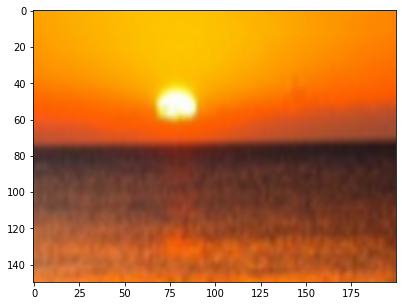

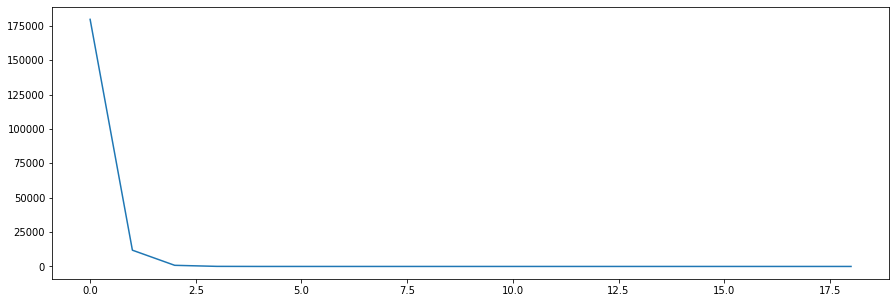

iter =  1 pas =  0.5 fonction =  164.82598735459646
iter =  2 pas =  0.5 fonction =  16.099828414167877
iter =  3 pas =  0.5 fonction =  3.810432197838788
iter =  4 pas =  0.5 fonction =  1.253217305155474
iter =  5 pas =  0.5 fonction =  0.8702904175694629
iter =  6 pas =  0.5 fonction =  0.7445950958586016
iter =  7 pas =  1.0 fonction =  0.7098233225530339
iter =  8 pas =  0.5 fonction =  0.7485963624857279
iter =  9 pas =  0.5 fonction =  0.7351504074839454


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 1
Fonctionnelle pour mu = 1


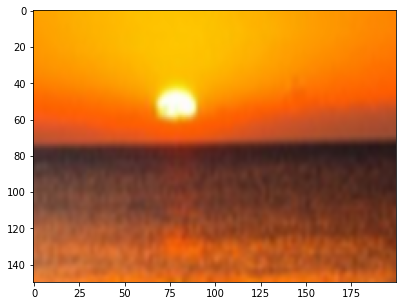

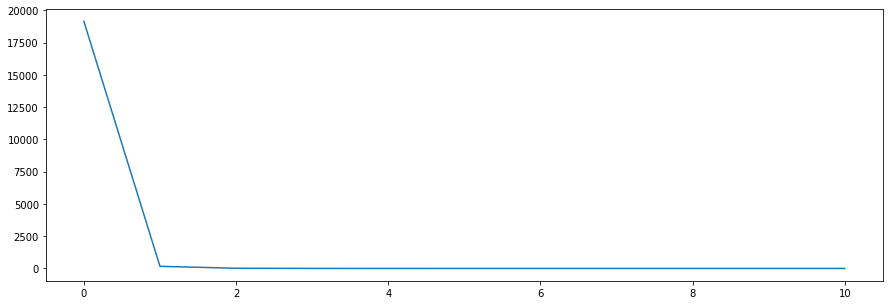

iter =  1 pas =  1.0 fonction =  1283.7849915671425
iter =  2 pas =  1.0 fonction =  726.8597131692181
iter =  3 pas =  1.0 fonction =  414.1363565627821
iter =  4 pas =  1.0 fonction =  266.46164685743474
iter =  5 pas =  1.0 fonction =  163.50682194209728
iter =  6 pas =  1.0 fonction =  93.16331048394765
iter =  7 pas =  1.0 fonction =  60.08939177801415
iter =  8 pas =  1.0 fonction =  34.30507401661677
iter =  9 pas =  1.0 fonction =  21.846213046426715
iter =  10 pas =  1.0 fonction =  14.20415956409348
iter =  11 pas =  1.0 fonction =  8.959528560430753
iter =  12 pas =  1.0 fonction =  5.7464464817419145
iter =  13 pas =  1.0 fonction =  3.8528246856490327
iter =  14 pas =  1.0 fonction =  2.5862271754869197
iter =  15 pas =  1.0 fonction =  1.772730917057687
iter =  16 pas =  1.0 fonction =  1.2565711404351825
iter =  17 pas =  1.0 fonction =  0.9215285610226883
iter =  18 pas =  1.0 fonction =  0.710671487604468
iter =  19 pas =  1.0 fonction =  0.5573183376000929
iter =  20 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.1
Fonctionnelle pour mu = 0.1


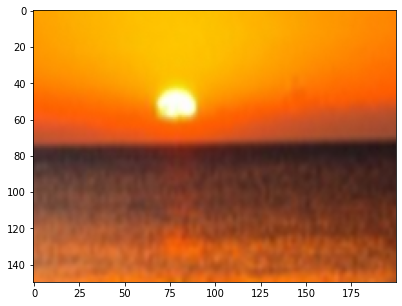

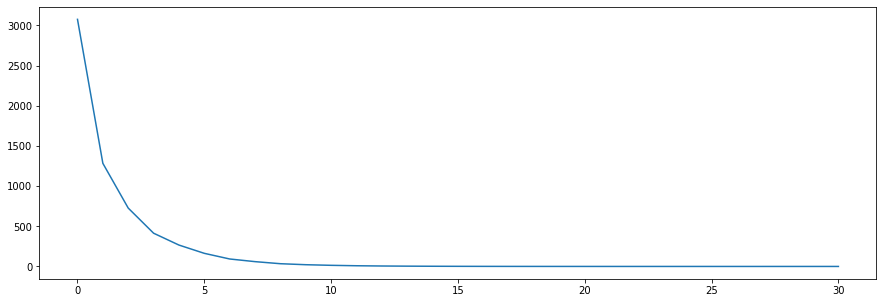

iter =  1 pas =  1.0 fonction =  583.5572421266153
iter =  2 pas =  1.0 fonction =  397.14260022769434
iter =  3 pas =  1.0 fonction =  309.54487561438566
iter =  4 pas =  1.0 fonction =  197.225768743473
iter =  5 pas =  1.0 fonction =  221.01413768044267
iter =  6 pas =  1.0 fonction =  155.27066696483428
iter =  7 pas =  1.0 fonction =  215.98583676205888
iter =  8 pas =  1.0 fonction =  181.7319957352911
iter =  9 pas =  1.0 fonction =  155.48490459136622
iter =  10 pas =  0.5 fonction =  125.45155875437374
iter =  11 pas =  1.0 fonction =  161.30137081847596
iter =  12 pas =  1.0 fonction =  131.308274403513
iter =  13 pas =  1.0 fonction =  128.06742506217967
iter =  14 pas =  1.0 fonction =  123.92981037997231
iter =  15 pas =  1.0 fonction =  93.44281377880992
iter =  16 pas =  1.0 fonction =  84.53339983237868
iter =  17 pas =  1.0 fonction =  78.01420757911086
iter =  18 pas =  1.0 fonction =  83.37640907859802
iter =  19 pas =  0.5 fonction =  72.7536387085281
iter =  20 pas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.01
Fonctionnelle pour mu = 0.01


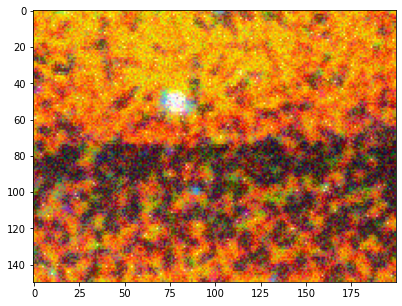

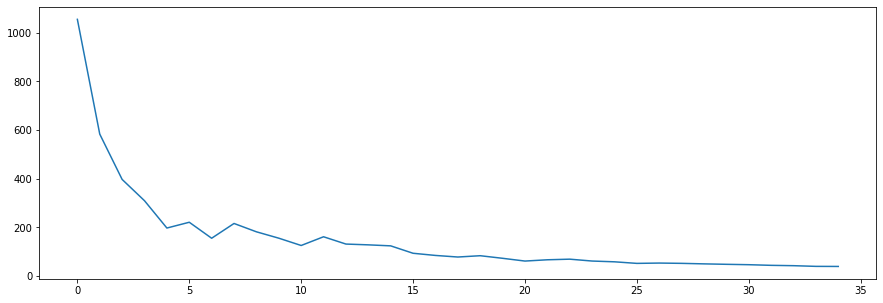

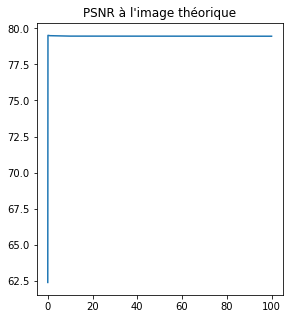

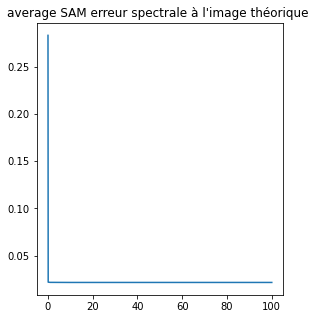

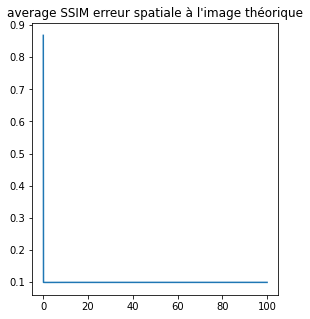

In [71]:
mu = [100, 10, 1, 0.1, 0.01]
errPSNR = []
errASAM = []
errACSSIM = []
for i in range(len(mu)):
    X, Fct = gradientDescente_pasRL(L_H, L_M, 2, 1, 3, 1, 1, mu[i], 5)
    errPSNR.append(PSNR(Xtrue, X))
    errASAM.append(aSAM(Xtrue, X))
    errACSSIM.append(acSSIM(Xtrue, X))
    print('Image reconstruire pour mu = '+str(mu[i])+'')
    plt.figure(figsize=(15,5))
    plt.imshow(X)
    print('Fonctionnelle pour mu = '+str(mu[i])+'')
    plt.figure(figsize=(15,5))
    plt.plot(Fct)
    plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(mu,errPSNR)
plt.title("PSNR à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(mu,errASAM)
plt.title("average SAM erreur spectrale à l'image théorique ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(mu,errACSSIM)
plt.title("average SSIM erreur spatiale à l'image théorique")

plt.show()

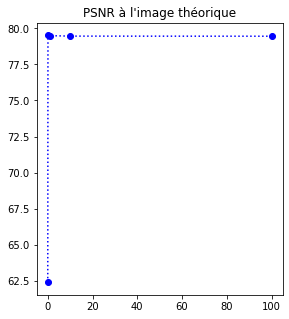

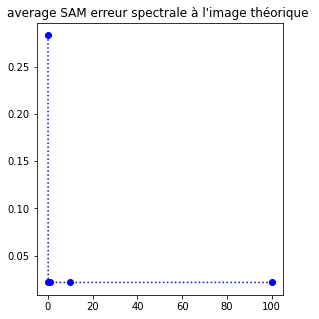

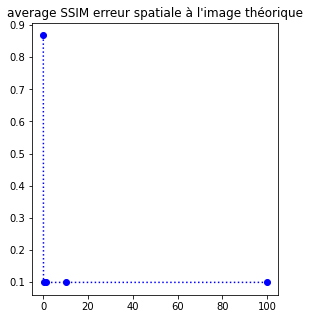

In [72]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(mu,errPSNR, "b:o")
plt.title("PSNR à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(mu,errASAM, "b:o")
plt.title("average SAM erreur spectrale à l'image théorique ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(mu,errACSSIM, "b:o")
plt.title("average SSIM erreur spatiale à l'image théorique")

plt.show()

In [76]:
mu.insert(0, 1000)

In [77]:
mu

[1000, 100, 10, 1, 0.1, 0.01]

In [82]:
X, Fct = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 1, 1, 1000, 5, 0.0002)

iter =  1 fonction =  6394980.586601146
iter =  2 fonction =  2302004.898210136
iter =  3 fonction =  828666.15565687
iter =  4 fonction =  298298.0140226069
iter =  5 fonction =  107377.01608472821
iter =  6 fonction =  38653.90559655481
iter =  7 fonction =  13914.417551192559
iter =  8 fonction =  5009.326421886639
iter =  9 fonction =  1803.7340338492409
iter =  10 fonction =  649.930590720578
iter =  11 fonction =  234.58860529276458
iter =  12 fonction =  85.03192906885927
iter =  13 fonction =  31.241401274828007
iter =  14 fonction =  11.87970125222756
iter =  15 fonction =  4.907993363244331
iter =  16 fonction =  2.3854012573055
iter =  17 fonction =  1.4875354697134142
iter =  18 fonction =  1.1228718373372142
iter =  19 fonction =  1.0598048944531904
iter =  20 fonction =  0.9990875499877279
iter =  21 fonction =  0.9766503971462474


In [86]:
errPSNR.insert(0, PSNR(Xtrue, X))
errASAM.insert(0, aSAM(Xtrue, X))
errACSSIM.insert(0, acSSIM(Xtrue, X))

In [92]:
errPSNR_Xinterp = PSNR(Xtrue, reech_interp(L_H, 2))
errASAM_Xinterp = aSAM(Xtrue, reech_interp(L_H, 2))
errACSSIM_Xinterp = acSSIM(Xtrue, reech_interp(L_H, 2))

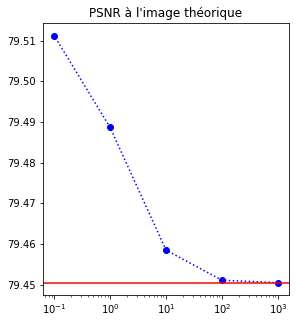

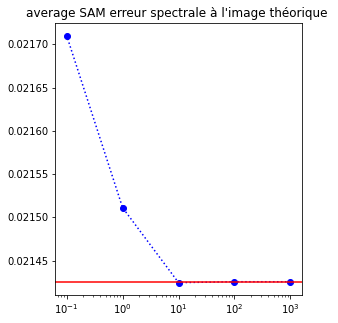

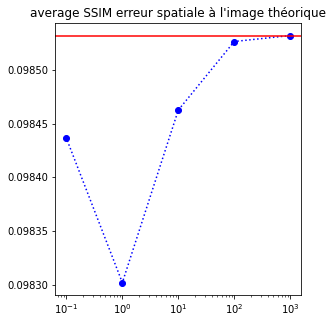

In [105]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.semilogx(mu[0:len(mu)-1],errPSNR[0:len(mu)-1], "b:o")
plt.axhline(errPSNR_Xinterp, color='red')
plt.title("PSNR à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.semilogx(mu[0:len(mu)-1],errASAM[0:len(mu)-1], "b:o")
plt.axhline(errASAM_Xinterp, color='red')
plt.title("average SAM erreur spectrale à l'image théorique ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.semilogx(mu[0:len(mu)-1],errACSSIM[0:len(mu)-1], "b:o")
plt.axhline(errACSSIM_Xinterp, color='red')
plt.title("average SSIM erreur spatiale à l'image théorique")

plt.show()